# GOLD PRICE PREDICTION
sources :

https://www.analyticsvidhya.com/blog/2021/05/stock-price-prediction-and-forecasting-using-stacked-lstm/#:~:text=LSTMs%20are%20widely%20used%20for,the%20information%20that%20is%20not.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('../dataset/gold.csv')
dataset_length = len(df)

In [3]:
df.head()

,Date,Open,High,Low,Close,Volume,Currency
0,2000-01-04,281.0,281.0,281.0,282.7,4,USD
1,2000-01-05,283.2,283.2,283.2,281.1,16,USD
2,2000-01-06,281.4,281.4,281.4,281.4,0,USD
3,2000-01-07,281.9,281.9,281.9,281.9,0,USD
4,2000-01-10,281.7,281.7,281.7,281.7,0,USD


# DATA PREPROCESSING : 
### Making it per month :

In [39]:
prices_in_month = {}
for i in range(dataset_length) :
    year_month = df.loc[i]["Date"][:7]
    try : ##if it exists in the dic
        prices_in_month[year_month] 
    except : ##else we create an empty list
        prices_in_month[year_month] = []
    prices_in_month[year_month].append(df.loc[i]["Close"])
    

In [40]:
# price_per_month = {}
# for k in prices_in_month :
#     avg = np.average(prices_in_month[k])
#     price_per_month[k] = [avg]

In [41]:
price_per_month = {
    "Date" : [],
    "Close": []
}
for k in prices_in_month :
    avg = np.average(prices_in_month[k])
    price_per_month["Date"].append(k) 
    price_per_month["Close"].append(avg) 
    

In [42]:
## make it a dataframe :
df1 = pd.DataFrame(price_per_month)
df1.head()

,Date,Close
0,2000-01,284.894737
1,2000-02,300.090000
2,2000-03,285.956522
3,2000-04,279.784211
4,2000-05,274.936364


In [8]:
df1 = df1["Close"]
df1

0       284.894737
1       300.090000
2       285.956522
3       279.784211
4       274.936364
          ...     
266    1960.521739
267    1944.180000
268    1853.232609
269    1838.936957
270    1806.300000
Name: Close, Length: 271, dtype: float64

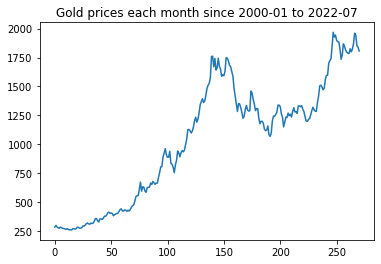

In [9]:
#plotting :
plt.plot(np.arange(len(df1)),df1)
plt.title("Gold prices each month since 2000-01 to 2022-07")
plt.show()

In [10]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

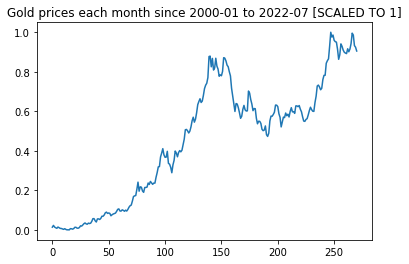

In [11]:
#plotting :
plt.plot(np.arange(271),df1)
plt.title("Gold prices each month since 2000-01 to 2022-07 [SCALED TO 1]")
plt.show()

# Train and Test Split

In [32]:
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
print("training size : {training_size}, test size : {test_size}".format(training_size = training_size, test_size = test_size))
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

training size : 176, test size : 95


In [33]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [34]:
time_step = 20
# timestep : basicaly how much should we look back to make a prediction
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [161]:
#idk for training reasons
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
print("final X train shape : {xtrainshape}\nfinal x test shape : {xtestshape}".format(xtrainshape = X_train.shape, xtestshape = X_test.shape))

final X train shape : (125, 50, 1)
final x test shape : (44, 50, 1)


In [27]:
X_test

array([[0.65971166, 0.63688862, 0.60332269, ..., 0.5517322 , 0.57582284,
        0.57516814],
       [0.63688862, 0.60332269, 0.61398004, ..., 0.57582284, 0.57516814,
        0.58402434],
       [0.60332269, 0.61398004, 0.61318298, ..., 0.57516814, 0.58402434,
        0.5954016 ],
       ...,
       [1.        , 0.97572605, 0.9856574 , ..., 0.91482475, 0.94237391,
        0.99536616],
       [0.97572605, 0.9856574 , 0.95923236, ..., 0.94237391, 0.99536616,
        0.98579478],
       [0.9856574 , 0.95923236, 0.9522937 , ..., 0.99536616, 0.98579478,
        0.93252672]])

### model building :

In [28]:
import keras
from keras.models import Sequential
from keras.layers import Dense,LSTM,Dropout


In [36]:
model=Sequential()
model.add(LSTM(128,return_sequences=True,input_shape=(time_step,1),activation='relu'))
model.add(Dropout(0.2))

model.add(LSTM(128,return_sequences=True,activation='relu'))
model.add(Dropout(0.2))

model.add(LSTM(128,activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1,activation='softmax'))

opt = keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss='mean_squared_error',
    optimizer=opt,
    metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 20, 128)           66560     
                                                                 
 dropout_3 (Dropout)         (None, 20, 128)           0         
                                                                 
 lstm_4 (LSTM)               (None, 20, 128)           131584    
                                                                 
 dropout_4 (Dropout)         (None, 20, 128)           0         
                                                                 
 lstm_5 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                

In [37]:
epochNumber = 100
model.fit(
    X_train,
    y_train,
    epochs= epochNumber,
    validation_data=(X_test, y_test)
)

Epoch 1/100
5/5 [==============================] - 6s 316ms/step - loss: 0.4814 - accuracy: 0.0000e+00 - val_loss: 0.0970 - val_accuracy: 0.0135
Epoch 2/100
5/5 [==============================] - 1s 147ms/step - loss: 0.4814 - accuracy: 0.0000e+00 - val_loss: 0.0970 - val_accuracy: 0.0135
Epoch 3/100
5/5 [==============================] - 1s 132ms/step - loss: 0.4814 - accuracy: 0.0000e+00 - val_loss: 0.0970 - val_accuracy: 0.0135
Epoch 4/100
5/5 [==============================] - 1s 124ms/step - loss: 0.4814 - accuracy: 0.0000e+00 - val_loss: 0.0970 - val_accuracy: 0.0135
Epoch 5/100
5/5 [==============================] - 1s 117ms/step - loss: 0.4814 - accuracy: 0.0000e+00 - val_loss: 0.0970 - val_accuracy: 0.0135
Epoch 6/100
5/5 [==============================] - 1s 120ms/step - loss: 0.4814 - accuracy: 0.0000e+00 - val_loss: 0.0970 - val_accuracy: 0.0135
Epoch 7/100
5/5 [==============================] - 1s 131ms/step - loss: 0.4814 - accuracy: 0.0000e+00 - val_loss: 0.0970 - val_ac

KeyboardInterrupt: 

In [132]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

2/2 [==============================] - 0s 45ms/step


In [133]:
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict[:,0]))

1094.4380233409195